In [29]:
# Importing required libraries
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_curve, auc, precision_score
# from sklearn.utils.fixes import signature
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag, ngrams
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import * #N-grams
import nltk.collocations #N-grams
from collections import Counter #N-grams
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wordcloud import WordCloud
import string
import seaborn as sns
#import matplotlib.pyplot as plt; plt.rcde|faults()
from matplotlib import rc
import matplotlib.pyplot as plt
import missingno as msno #missmap
import numpy as np
import pandas as pd 
import os

# DATA PREPARATION AND WRANGLING
****
This data was provided by a third party source called Appfollow. It is a collection of the reviews on the canvas student app between 20/03/2020 and 27/03/2022

## Data Description

The app store data used here is a concatenation of two files  with 9847 common observations and 31 columns. Each customer review is composed of Date, AppID, AppName,Language,Version, Version Code, Rating, Title, Review, Translated title, Translated  review, Reply Date, Developer Reply, User, Device, Device Type,Tags, Categories, Notes, Likes, Dislikes, Link, Permalink, AF Link.            

In [2]:
df1 = pd.read_csv("reviews_googleplay_1646499793.csv", encoding = "ISO-8859-1", skiprows=2) #loading the data
df2 = pd.read_csv("reviews_googleplay_1646500302.csv", encoding = "ISO-8859-1", skiprows=2) #loading the data
df3 = pd.read_csv("reviews_itunes_1648403710.xls", encoding = "ISO-8859-1", skiprows=2) #loading the data

#concatenate both dataframes and drop duplicates
df = pd.concat([df1,df2,df3]).drop_duplicates().reset_index(drop=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18813 entries, 0 to 18812
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 18813 non-null  object 
 1   AppID                18813 non-null  object 
 2   AppName              18813 non-null  object 
 3   Language             9847 non-null   object 
 4   Review Language      18785 non-null  object 
 5   Version              17200 non-null  object 
 6   VersionCode          0 non-null      float64
 7   OS                   0 non-null      float64
 8   Author               18813 non-null  object 
 9   Rating               18813 non-null  int64  
 10  Title                8967 non-null   object 
 11  Review               18813 non-null  object 
 12  Translated title     0 non-null      float64
 13  Translated review    0 non-null      float64
 14  Reply Date           578 non-null    object 
 15  Developer Reply      578 non-null   

For the sake of our analysis, the dataset is redefined to include only features that are meaningful to the analysis.

In [3]:
df = df.drop(["Author","AppName","Version","VersionCode","OS","Review Language","Language","Translated title", "Translated review", "Reply Date","Developer Reply","User","Device","Device Type","Tags","Notes","Link","Likes","Dislikes","Permalink","AF Link","Categories","Title", "Updated", "Semantic Tags", "AppID", "Semantic Categories", "Semantic Sentiment", "Tags", "Notes", "Country", "Date", "Rating"], axis=1)

In [4]:
df.head(5)

,Review
0,So helpful to have this available on my phone ...
1,I love this app Mustang public schools use it ...
2,its been great easy to navagate and use for my...
3,Easy to use
4,This app has what you really need for a virtua...


In [5]:
print('Dimensions:',df.shape)
df.columns

Dimensions: (18813, 1)


Index(['Review'], dtype='object')

## Preprocessing data for label generation and a Random Forest 

> I will lemmatize the words to transform them to their base form and ensure the preservation of the context of the words. To achieve this however, the words have to be matched to their appropriate part of speech tag. The function below defines the word type based on the position tag obtained from the NLTK pos_tag module.
The function is then implemented in the text cleaning function in the following section of code.
Code for both functions were gleaned from here


In [6]:
#df['Reviews_to_clean'] = df['Review']
df.head()

,Review
0,So helpful to have this available on my phone ...
1,I love this app Mustang public schools use it ...
2,its been great easy to navagate and use for my...
3,Easy to use
4,This app has what you really need for a virtua...


In [7]:
def get_tag(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

According to Ogunlesi in the referenced source, The clean_text function defined below applies the following transformations:

1) Change all words to lower case (lemmatization does not work on capitals as they are assumed to be proper nouns).

2) Tokenize the text and remove punctuation.

3) Remove numeric values.

4) Remove stop words (using pre-built stop word dictionary).

5) Remove any empty tokens.

6) Apply a position tag to each word and define it based on the previously defined get_tag function as adjective, noun, verb, or adverb.

7) Lemmatize the words.

8) Remove any single letter words resulting from lemmatization.

In [8]:
import re
def clean_text(text):
    text = text.lower() #change all text to lower case
    text = re.sub(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+','',text)
    text = [word.strip(string.punctuation) for word in text.split(" ")] #tokenize and remove punctuation
    text = [word for word in text if not any(c.isdigit() for c in word)] #remove numeric values
    stop = stopwords.words('english') #call english stop word dictionary
    text = [x for x in text if x not in stop]#remove stop words
    text = [t for t in text if len(t) > 0] #remove empty tokens
    pos_tags = pos_tag(text)#apply position tag to text
    text = [WordNetLemmatizer().lemmatize(t[0], get_tag(t[1])) for t in pos_tags] #apply pos_tag function and lemmatize text
    text = [t for t in text if len(t) > 1]# remove single letter words
    text = " ".join(text) #combine
    return(text)
#create new column with cleaned text
df["preprocessed_reviews"] = df["Review"].apply(lambda x: clean_text(x))

In [9]:
#Text Before Text Cleaning
print('Before Text Cleaning')
df['Review'].head(3)


Before Text Cleaning


0    So helpful to have this available on my phone ...
1    I love this app Mustang public schools use it ...
2    its been great easy to navagate and use for my...
Name: Review, dtype: object

In [10]:
#Text After Text Cleaning
print('After Text Cleaning')
df['preprocessed_reviews'].head(3)


After Text Cleaning


0                       helpful available phone tablet
1    love app mustang public school use homework di...
2            great easy navagate use nephew keep grade
Name: preprocessed_reviews, dtype: object

## Cleaning data for Neural network classification (No stemming/Lemmatization)

In [11]:
def depure_data(data): 
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data
#create new column with cleaned text
df["cleaned_reviews"] = df["Review"].apply(lambda x: depure_data(x)) 


In [12]:
#Text Before Text Cleaning
print('Before Text Cleaning')
df['Review'].head(5)


Before Text Cleaning


0    So helpful to have this available on my phone ...
1    I love this app Mustang public schools use it ...
2    its been great easy to navagate and use for my...
3                                          Easy to use
4    This app has what you really need for a virtua...
Name: Review, dtype: object

In [13]:
#Text After Text Cleaning
print('After Text Cleaning')
df['cleaned_reviews'].head(5)

After Text Cleaning


0    So helpful to have this available on my phone ...
1    I love this app Mustang public schools use it ...
2    its been great easy to navagate and use for my...
3                                          Easy to use
4    This app has what you really need for a virtua...
Name: cleaned_reviews, dtype: object

In [14]:
# Drop all rows that are blank as a results of the text cleaning functions. Lost ??? rows.
print(df.shape)
df = df[df['preprocessed_reviews'].map(len) > 0]
print(df.shape)


(18813, 3)
(18639, 3)


# DATA ANNOTATION

> Indented block


***
### Sentiment Analysis
The Vader module from NLTK was the model selected for sentiment analysis. The Vader module uses a prebuilt lexicon of words to calculate a sentiment score and generate the data labels. This module was selected for sentiment analysis because the module takes into consideration the context of the text. The module returns 4 values: positivity score, neutrality score, negativity score and summary score.

In [15]:
SIA = SentimentIntensityAnalyzer()
#calculates the negativity,  neutrality, positivity and overall sentiment scores
df["sentiments"] = df["preprocessed_reviews"].apply(lambda x: SIA.polarity_scores(x))
#drop sentiment column and add the 4 sentiment scores as separate features to primary dataset
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

df[['preprocessed_reviews','neg','neu','pos','compound']].head(10)

,preprocessed_reviews,neg,neu,pos,compound
0,helpful available phone tablet,0.000,0.517,0.483,0.4215
1,love app mustang public school use homework di...,0.000,0.582,0.418,0.9607
2,great easy navagate use nephew keep grade,0.000,0.417,0.583,0.7906
3,easy use,0.000,0.256,0.744,0.4404
4,app really need virtual classroom,0.000,1.000,0.000,0.0000
5,exchange student use app semester help lot,0.000,0.690,0.310,0.4019
6,rare issue app wish inscribe forum easy view i...,0.000,0.554,0.446,0.9022
7,every app i've ever use glitch every we've hic...,0.044,0.753,0.203,0.8220
8,help can't sign computer,0.000,0.526,0.474,0.4019
9,awesome,0.000,0.000,1.000,0.6249


# Define Labels (Good and Bad Reviews)

In [16]:
def sentiments(data):
    score = data['compound'].values
    sentiment = []
    
    for i in score:
        if i >= 0.05 : 
            sentiment.append("positive")
        elif i <= -0.05 :
            sentiment.append("negative")
        else:
            sentiment.append("neutral")
    data['sentiment'] = sentiment 
    return data

#generate the labels
df = sentiments(df)

# remove the neutral labels from 
df_neutral = df[df['sentiment'] == 'neutral']

df = df[~df.index.isin(df_neutral.index)]
df.head()


,Review,preprocessed_reviews,cleaned_reviews,neg,neu,pos,compound,sentiment
0,So helpful to have this available on my phone ...,helpful available phone tablet,So helpful to have this available on my phone ...,0.0,0.517,0.483,0.4215,positive
1,I love this app Mustang public schools use it ...,love app mustang public school use homework di...,I love this app Mustang public schools use it ...,0.0,0.582,0.418,0.9607,positive
2,its been great easy to navagate and use for my...,great easy navagate use nephew keep grade,its been great easy to navagate and use for my...,0.0,0.417,0.583,0.7906,positive
3,Easy to use,easy use,Easy to use,0.0,0.256,0.744,0.4404,positive
5,I was an exchange student so I only used this ...,exchange student use app semester help lot,I was an exchange student so I only used this ...,0.0,0.690,0.310,0.4019,positive


## Transforming Labels and Features

Positive (1) vs Negative (0) split:
 positive    0.706296
negative    0.293704
Name: sentiment, dtype: float64


Text(0.5, 1.0, 'Sentiment Score Distribution by Review Type')

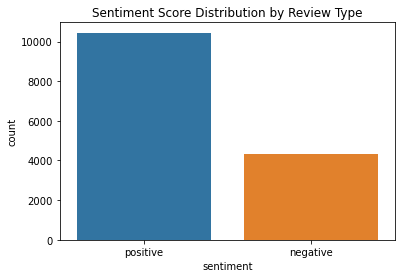

In [17]:
# For labels 
sentiments =df['sentiment'].values

y = pd.get_dummies(df['sentiment']).values

print ("Positive (1) vs Negative (0) split:" "\n", df["sentiment"].value_counts(normalize = True))
sns.countplot(df['sentiment']).set_title('Sentiment Score Distribution by Review Type')


In [18]:
y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [19]:
# Feature selection
#ignore_cols = ['Date', 'Rating', 'Review', 'neg', 'neu', 'pos', 'compound', 'sentiment']


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

df['cleaned_reviews'] = df['cleaned_reviews'].apply(lambda x: x.lower())
X= df['cleaned_reviews']

max_words = 2000

tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(X.values)

sequences = tokenizer.texts_to_sequences(X.values)
review = pad_sequences(sequences)
print(review)

[[  0   0   0 ...   5  10 652]
 [  0   0   0 ...   8  56 110]
 [  0   0   0 ...  12 541  74]
 ...
 [  0   0   0 ... 126  42   6]
 [  0   0   0 ...  97   1 490]
 [  0   0   0 ...   4 753  12]]


# MODEL DEVELOPMENT



In [20]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras.layers import Dense, Dropout 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
max_words = 2000
embed_dim = 128
lstm_out = 190

model = Sequential()
model.add(Embedding(max_words, embed_dim,input_length = review.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))


model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 583, 128)          256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 583, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 190)               242440    
                                                                 
 dense (Dense)               (None, 2)                 382       
                                                                 
Total params: 498,822
Trainable params: 498,822
Non-trainable params: 0
_________________________________________________________________
None


# Training the model



In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(review,y, test_size = 0.25, random_state = 0)

In [22]:
X_train

array([[  0,   0,   0, ...,   3,  61,  26],
       [  0,   0,   0, ...,  67,  13, 207],
       [  0,   0,   0, ...,  20,  33, 358],
       ...,
       [  0,   0,   0, ...,   0, 130, 336],
       [  0,   0,   0, ...,  40,  58,  20],
       [  0,   0,   0, ...,  35,   1,  23]])

In [23]:
y_train

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

## Balancing our label class

To address any imbalance in the datset and improve generalization of the model

#resampling with SmoteTomek
print("The number of classes before resampling {}".format(Counter(y_train)))

from imblearn.combine import SMOTETomek
smt=SMOTETomek()
X_train_,y_train_=smt.fit_resample(X_train,y_train)

print("The number of classes after resampling {}".format(Counter(y_train_)))

In [24]:
# train the Neural network.    
history = model.fit(X_train, y_train, epochs=10, verbose = 1, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
347/347 [==============================] - 1555s 4s/step - loss: 0.3614 - accuracy: 0.8391 - val_loss: 0.2624 - val_accuracy: 0.8869
Epoch 2/10
347/347 [==============================] - 1715s 5s/step - loss: 0.1854 - accuracy: 0.9269 - val_loss: 0.2141 - val_accuracy: 0.9170
Epoch 3/10
347/347 [==============================] - 1627s 5s/step - loss: 0.1474 - accuracy: 0.9445 - val_loss: 0.2117 - val_accuracy: 0.9118
Epoch 4/10
347/347 [==============================] - 1649s 5s/step - loss: 0.1180 - accuracy: 0.9564 - val_loss: 0.2016 - val_accuracy: 0.9218
Epoch 5/10
347/347 [==============================] - 1700s 5s/step - loss: 0.0977 - accuracy: 0.9634 - val_loss: 0.2312 - val_accuracy: 0.9145
Epoch 6/10
347/347 [==============================] - 1560s 4s/step - loss: 0.0828 - accuracy: 0.9699 - val_loss: 0.2431 - val_accuracy: 0.9210
Epoch 7/10
347/347 [==============================] - 1673s 5s/step - loss: 0.0689 - accuracy: 0.9757 - val_loss: 0.3115 - val_accuracy:

# Evaluating the model's performance

Test accuracy: 0.9161482453346252


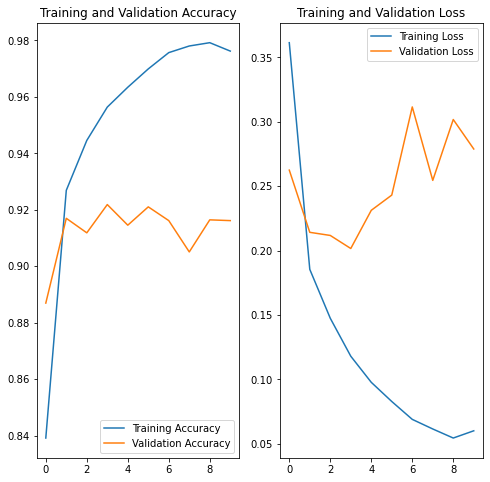

In [25]:
#visualize model's performance metrics
import matplotlib.pyplot as plt
epochs = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs) 
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

# Define a function to plot the metrics of a model's performance
def plot_acc_loss():
    plt.figure(figsize=(8, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
#visualize model's performance metrics
plot_acc_loss()

### Classification Report:
The model achieved an average precision of ???, average recall of ?? and average accuracy of ??. We can see the model has higher precision when it comes to predicting positive review. This may be because the positive sentiment is one of most important feature for our model (refer to Feature Importance section).



In [44]:
# generating predictions on the test data
y_pred=model.predict(X_test,verbose=2)
##define 1D array to generate classification report
y_pred=np.argmax(y_pred,axis=1)

# extract the predicted class labels
#y_pred = np.where(y_pred_prob > 0.5, 1, 0)
print(y_pred)

116/116 - 70s - 70s/epoch - 607ms/step
[1 1 0 ... 1 1 1]


Recall: 0.9318095238095238
Accuracy score: 0.9161482282932107
Precision score: 0.9491656965463717
None


Text(0.5, 15.0, 'Predicted label')

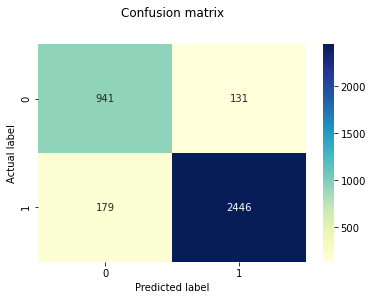

In [45]:
##define 1D array to generate classification report
y_test_unecoded=np.argmax(y_test, axis=1)

def class_report(ytest, y_pred, name=''):  
    recall = recall_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    acc = accuracy_score(ytest, y_pred)
    print(f'Recall: {recall}')
    print(f'Accuracy score: {acc}')
    print(f'Precision score: {precision}')

# evaluate the model
report = class_report(y_test_unecoded, y_pred)
print(report)

cnf_matrix = confusion_matrix(y_test_unecoded, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

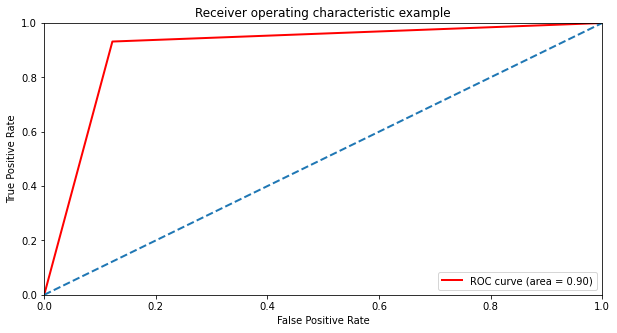

In [49]:
fpr, tpr, thresholds = roc_curve(y_test_unecoded, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure(1, figsize = (10, 5))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Assessing Model against alternative benchmark settings

### Neural network Architecture - Bidirectional Neural network 

In [52]:
model2 = Sequential()
model2.add(Embedding(max_words, embed_dim,input_length = review.shape[1]))
model2.add(SpatialDropout1D(0.2))
model2.add(layers.Bidirectional(layers.LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
           
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 583, 128)          256000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 583, 128)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 380)              484880    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 2)                 762       
                                                                 
Total params: 741,642
Trainable params: 741,642
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
347/347 [==============================] - 4425s 13s/step - loss: 0.0388 - accuracy: 0.9839 - val_loss: 0.3053 - val_accuracy: 0.9145
Epoch 2/10
347/347 [==============================] - 4458s 13s/step - loss: 0.0386 - accuracy: 0.9851 - val_loss: 0.3603 - val_accuracy: 0.9145
Epoch 3/10
347/347 [==============================] - 4501s 13s/step - loss: 0.0417 - accuracy: 0.9848 - val_loss: 0.3860 - val_accuracy: 0.9132
Epoch 4/10
347/347 [==============================] - 5145s 15s/step - loss: 0.0353 - accuracy: 0.9871 - val_loss: 0.3445 - val_accuracy: 0.9140
Epoch 5/10
347/347 [==============================] - 4912s 14s/step - loss: 0.0473 - accuracy: 0.9844 - val_loss: 0.3596 - val_accuracy: 0.9194
Epoch 6/10
347/347 [==============================] - 4795s 14s/step - loss: 0.0269 - accuracy: 0.9907 - val_loss: 0.3979 - val_accuracy: 0.9137
Epoch 7/10
347/347 [==============================] - 4582s 13s/step - loss: 0.0208 - accuracy: 0.9915 - val_loss: 0.3975 - val_ac

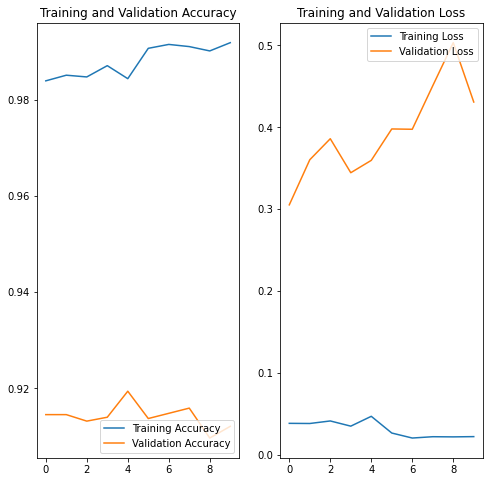

In [54]:
# train the Neural network.
history = model2.fit(X_train, y_train, epochs=10, verbose = 1, validation_data=(X_test, y_test))

#visualize model's performance metrics
epochs = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs) 

score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

#visualize model's performance metrics
plot_acc_loss()

#### Evaluating the model

In [ ]:
# generating predictions on the test data
y_pred=model2.predict(X_test,verbose=2)

##define 1D array to generate classification report
y_pred=np.argmax(y_pred,axis=1)



# evaluate the model
##define 1D array to generate classification report
y_test_unecoded=np.argmax(y_test, axis=1)

# evaluate the model
report = class_report(y_test_unecoded, y_pred)
print(report)

cnf_matrix = confusion_matrix(y_test_unecoded, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

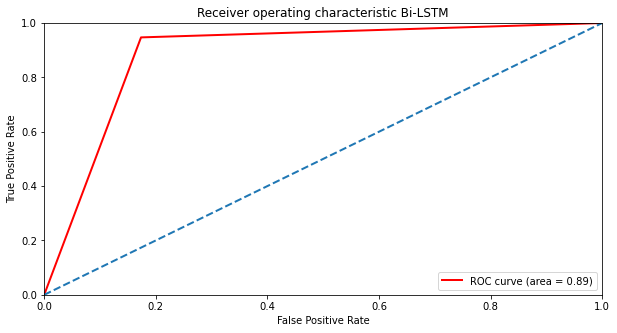

In [67]:
fpr, tpr, thresholds = roc_curve(y_test_unecoded, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure(1, figsize = (10, 5))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Bi-LSTM')
plt.legend(loc="lower right")
plt.show()

### Different model set up - A Random Forest Classifier  (RFC) 

#### Preprocessing data for RFC

In [20]:
cv = CountVectorizer() 
X2 = cv.fit_transform(df['preprocessed_reviews']).toarray()# redefine training and test data

from sklearn.model_selection import train_test_split
X2_train, X2_test, y_train, y_test = train_test_split(X2,y, test_size = 0.25, random_state = 0)
y_train = np.argmax(y_train, axis=1)

#### Training the model

In [22]:
from sklearn.ensemble import RandomForestClassifier
# train a random forest classifier
rfc = RandomForestClassifier(n_estimators = 150, random_state = 101)
rfc.fit(X2_train,y_train) 

RandomForestClassifier(n_estimators=150, random_state=101)

#### Evaluating the model

1.0
Recall: 0.96
Accuracy score: 0.9169596970516635
Precision score: 0.925789860396767
None


Text(0.5, 15.0, 'Predicted label')

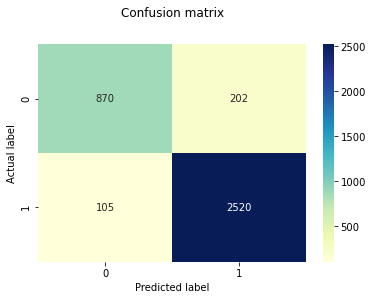

In [30]:
rfc_training_accuracy = accuracy_score(y_train, rfc.predict(X2_train))
print(rfc_training_accuracy)

# making predictions on the unseen data
rfc_pred=rfc.predict(X2_test)

##define 1D array to generate classification report
#rfc_pred=np.argmax(rfc_pred,axis=1)



# evaluate the model
##define 1D array to generate classification report
y_test_unecoded=np.argmax(y_test, axis=1)


def class_report(ytest, y_pred, name=''):  
    recall = recall_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    acc = accuracy_score(ytest, y_pred)
    print(f'Recall: {recall}')
    print(f'Accuracy score: {acc}')
    print(f'Precision score: {precision}')
    
# evaluate the model
baseline_report = class_report(y_test_unecoded, rfc_pred.round())
print(baseline_report)

cnf_matrix = confusion_matrix(y_test_unecoded, rfc_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

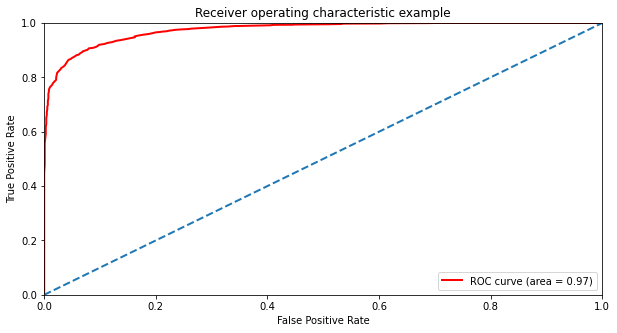

In [33]:
rfc_prob_pred = [x[1] for x in rfc.predict_proba(X2_test)]
fpr, tpr, thresholds = roc_curve(y_test_unecoded, rfc_prob_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure(1, figsize = (10, 5))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()